Import all necessary files:

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import shapiro

# Warnings
import warnings
warnings.filterwarnings('ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)

Load the app dataset and getting a view of it:

In [51]:
path = "H:\\Data Science\\Financal Projects\\Cookie Cats App\\cookie_cats.csv"

def load(path, info=True):
    
    import io

    if len(path.split(".csv")) > 1:
        data = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        data = pd.read_excel(path)

    if info:
        if len(data) > 0:
            print('# Data Imported!')
            print("# ------------------------------------", "\n")

            print("# Dimensions -------------------------")
            print("Observations:", data.shape[0], "Features:", data.shape[1], "\n")

            print("# dtypes -----------------------------")
            if len(data.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(data.select_dtypes("object").columns), "\n", 
                      data.select_dtypes("object").columns.tolist(), "\n")
    
            if len(data.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(data.select_dtypes("integer").columns), "\n", 
                      data.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(data.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:", 
                      len(data.select_dtypes("float").columns), "\n", 
                      data.select_dtypes("float").columns.tolist(), "\n")
    
            if len(data.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(data.select_dtypes("bool").columns), "\n", 
                      data.select_dtypes("bool").columns.tolist(), "\n")
    
            print("# Missing Values ---------------------")
            print("Are there any missing values? \n ", np.where(data.isnull().values.any() == False, 
                                                            "No missing value!", "Data includes missing value!"), "\n")
            
            buf = io.StringIO()
            data.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# Memory Usage ---------------------- \n", info)
          
        else:
            print("# Dataset did not import!")
    
    return data

data = load(path)

# Data Imported!
# ------------------------------------ 

# Dimensions -------------------------
Observations: 90189 Features: 5 

# dtypes -----------------------------
Object Variables: 
 # of Variables: 1 
 ['version'] 

Integer Variables: 
 # of Variables: 2 
 ['userid', 'sum_gamerounds'] 

Bool Variables: 
 # of Variables: 2 
 ['retention_1', 'retention_7'] 

# Missing Values ---------------------
Are there any missing values? 
  No missing value! 

# Memory Usage ---------------------- 
 2.2+ MB


In [52]:
data.sample(10)

,userid,version,sum_gamerounds,retention_1,retention_7
76643,8486694,gate_30,20,False,False
45226,5010051,gate_40,137,True,False
48174,5344492,gate_40,102,True,False
8336,919315,gate_40,32,True,False
45528,5042434,gate_40,24,True,False
63712,7056016,gate_30,83,True,False
20643,2298012,gate_40,35,True,False
3025,333740,gate_40,5,False,False
82034,9089851,gate_30,1,False,False
5224,578975,gate_30,55,False,False


We must make sure that we do not have duplicate userid:

In [53]:
data.duplicated().sum()

np.int64(0)

Get some statistical knowledge about the total number of rounds each user has played since installation:

In [54]:
data.describe()[['sum_gamerounds']].T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,5.0,16.0,51.0,49854.0


Result:
 
1- Half of the players have not played more than 16 rounds! It is a small number!

2- pay attention to this number, 3/4 players have not played more than 51 rounds!

3- The maximum number of rounds completed by a player is 49,854 rounds.

4- Maybe the players become interested in the game after the third quarter and remain loyal after that.

5- We also have users who install the game but don't even start the game.

Anyway, this is not good at all and we should try to get the people who have installed the game interested in the game much earlier.


We tried to get some statistical knowledge on the players by different versions of A (gate_30), B (gate_40):

In [55]:
data.groupby('version').sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'max'])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


Result: The standard deviation and maximum of the two versions have significant differences. We did not expect this!
It is possible that we will face outlier data in the A version.

Let us check this case (outliers) with a chart:

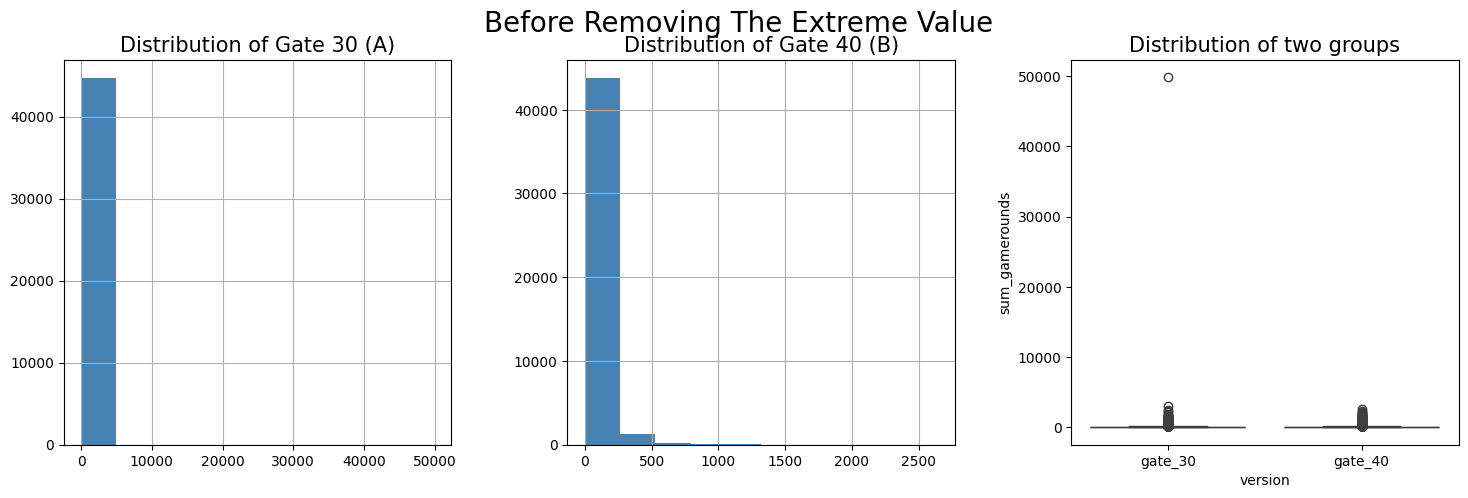

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

data[(data.version == 'gate_30')].hist('sum_gamerounds', ax=axes[0], color='steelblue')
data[(data.version == 'gate_40')].hist('sum_gamerounds', ax=axes[1], color='steelblue')

sns.boxplot(x=data.version, y=data.sum_gamerounds, ax = axes[2])

plt.suptitle('Before Removing The Extreme Value', fontsize=20)
axes[0].set_title('Distribution of Gate 30 (A)', fontsize=15)
axes[1].set_title('Distribution of Gate 40 (B)', fontsize=15)
axes[2].set_title('Distribution of two groups', fontsize=15)

plt.show()

Result: As we can see, there is a strange difference between the number of rounds of one player and others.

I'd be interested in inviting that player to a Luxury restaurant if he/she live in the US and asking why? :))

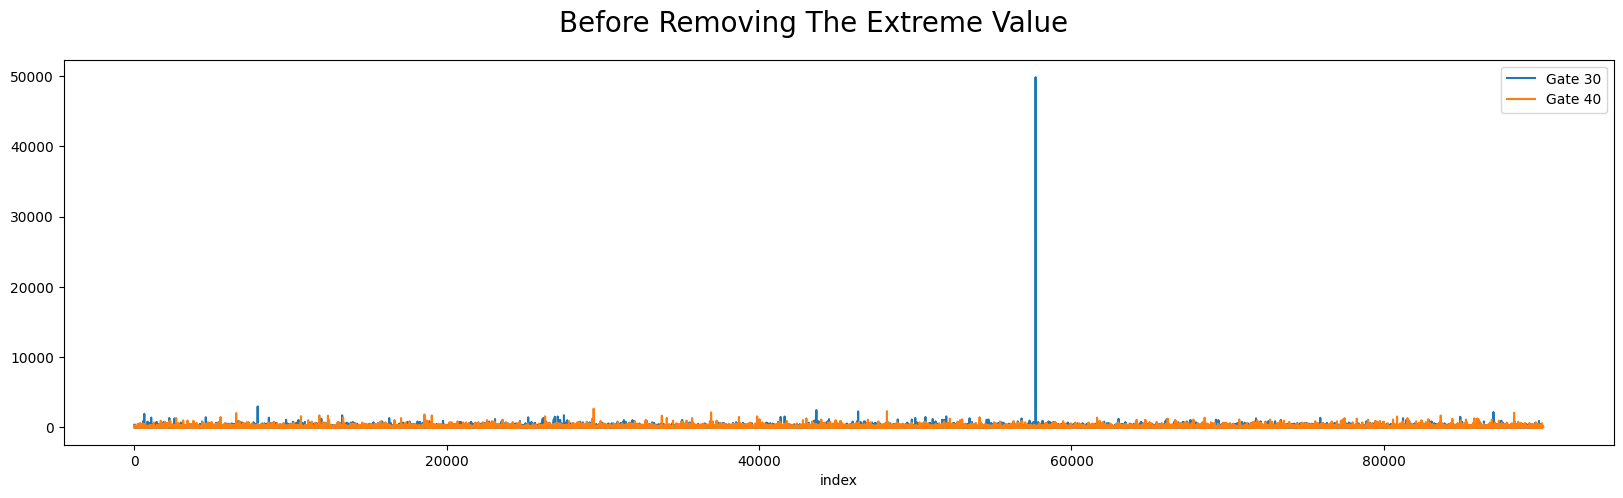

In [57]:
data[data.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
data[data.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20)

plt.show()

Result: Also in above chart, you are able to quickly identify outlier. (sum_gamerounds - userid)

We want to remove that outlier (our loyal player) from our study dataset. Because most of the players get tired of the game early and we are going to identify this cause and solve it with solutions:

In [58]:
data = data[data.sum_gamerounds < data.sum_gamerounds.max()]

In [59]:
data.describe()[["sum_gamerounds"]].T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,90188.0,51.320253,102.682719,0.0,5.0,16.0,51.0,2961.0


Now, if we want to check with the chart, we will find that the players are not significantly different from each other.

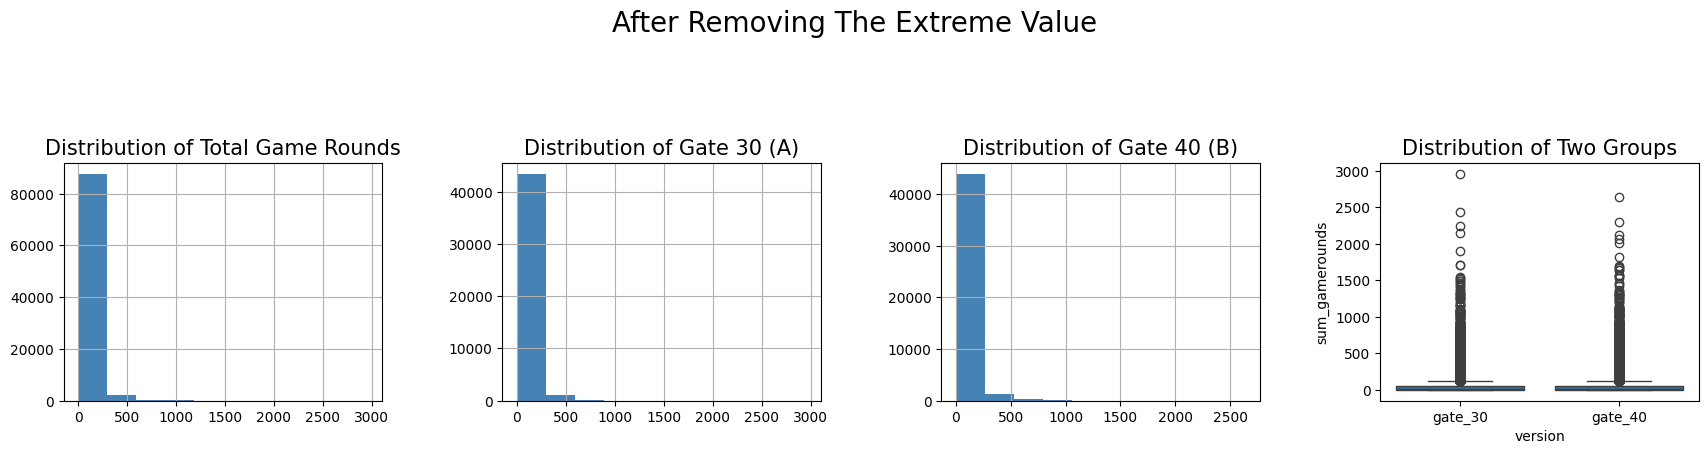

In [60]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
data.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
data[(data.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
data[(data.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = data.version, y = data.sum_gamerounds, ax = axes[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4)
plt.show()

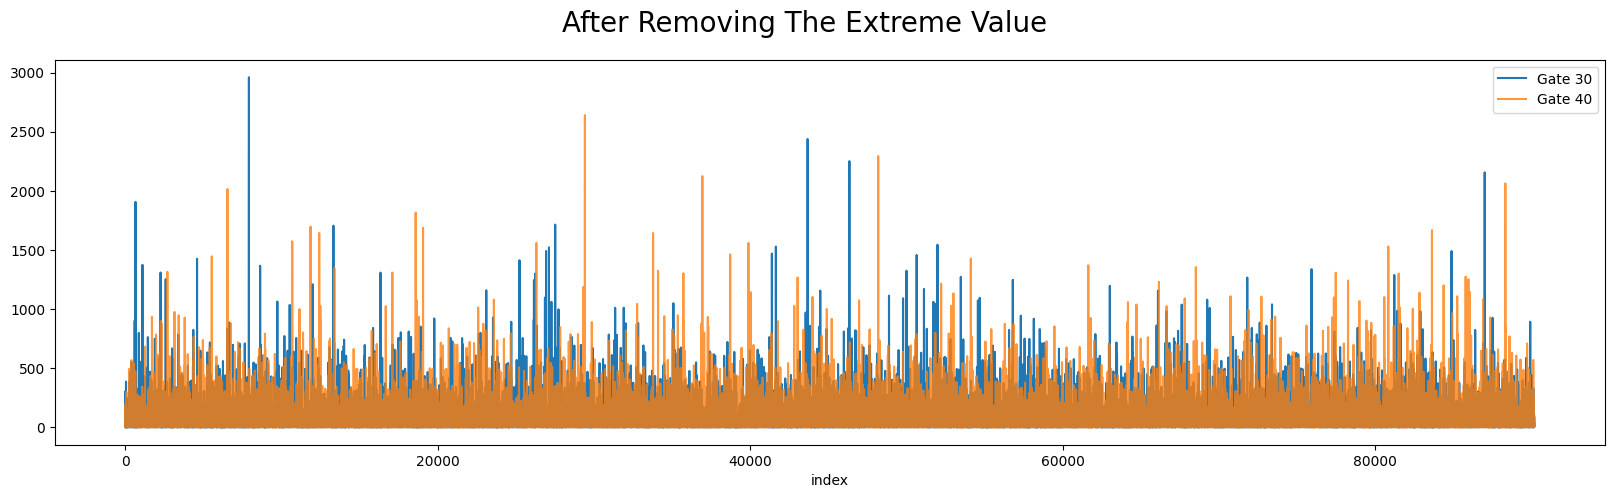

In [61]:
data[(data.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
data[data.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20)

plt.show()

Now let's talk about why some users install the game but don't even start it?

In [62]:
len(data[data['sum_gamerounds'] == 0])

3994

Result: About 4000 of our 90000 installations are in this group.

Now let's talk about people who start playing, but they get tired of the game very soon. We can measure this group of people with two features, 'retention_1' and 'retension_7'.

In [63]:
len(data[(data['retention_1'] == True) & (data['retention_7'] == False)])

26971

Result: About 27,000 of our 90,000 installations get bored of the game within a day to a week.

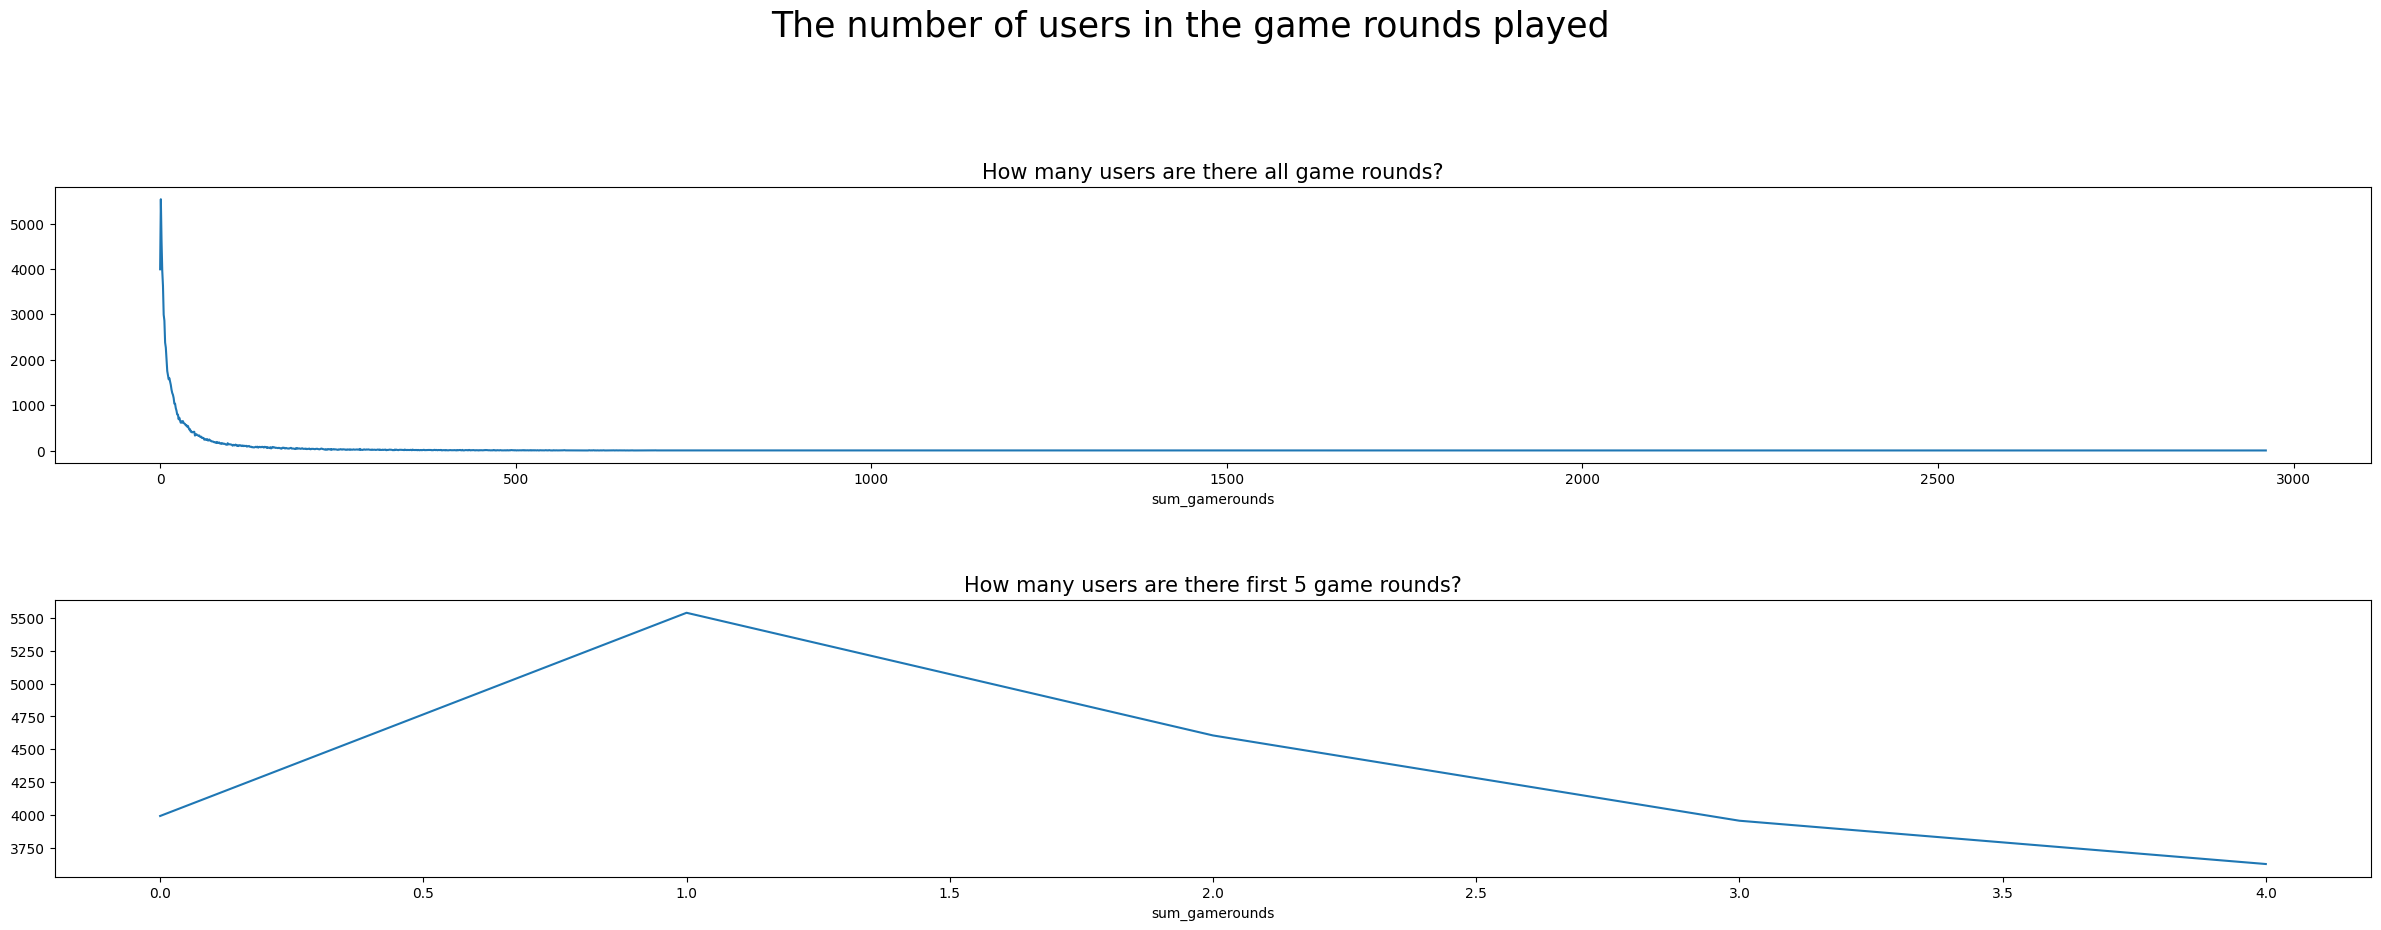

In [64]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
data.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
data.groupby("sum_gamerounds").userid.count()[:5].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 5 game rounds?", fontsize = 15)

plt.tight_layout(pad=5)
plt.show()

Result: According to the chart, most of the people who install play for one round, and after one round, a large number of players quit. Even the game has not been able to maintain its charm for two rounds, which puts the game at serious risk.

The distribution of players between version A (gate_30) and B (gate_40) is almost the same:

In [65]:
data.groupby('sum_gamerounds').userid.count().reset_index().loc[[30, 40]]

,sum_gamerounds,userid
30,30,642
40,40,505


After removing the outlier, the maximum and variance in the two versions (A / B) are not significantly different:

In [66]:
data.groupby('version').sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


In [67]:
pd.DataFrame({
    'RET1_COUNT': data['retention_1'].value_counts(),
    'RET7_COUNT': data['retention_7'].value_counts(),
    'RET1_PERCENTAGE': (data['retention_1'].value_counts() / len(data)) * 100,
    'RET7_PERCENTAGE': (data['retention_7'].value_counts() / len(data)) * 100
})

,RET1_COUNT,RET7_COUNT,RET1_PERCENTAGE,RET7_PERCENTAGE
False,50035,73408,55.478556,81.394421
True,40153,16780,44.521444,18.605579


Result: 55% of people who have installed it, get tired of the game after one day. Also, 81% of people get tired of the game after a week.

We make the same comparison above by different versions:

Retention after a day:

In [68]:
data.groupby(['version', 'retention_1']).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median       mean         std   max
version retention_1                                            
gate_30 False        24665     6.0  16.359092   36.528426  1072
        True         20034    48.0  94.411700  135.037697  2961
gate_40 False        25370     6.0  16.340402   35.925756  1241
        True         20119    49.0  95.381182  137.887256  2640

Retention after a week:

In [69]:
data.groupby(['version', 'retention_7']).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198    11.0   25.796508   43.316158   981
        True          8501   105.0  160.117516  179.358560  2961
gate_40 False        37210    11.0   25.856356   44.406112  2640
        True          8279   111.0  165.649837  183.792499  2294

Retention after a day and after a week and so on and so forth:

In [70]:
data['retention'] = np.where((data.retention_1 == True) & (data.retention_7 == True), 1, 0)

data.groupby(['version', 'retention'])['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention                                             
gate_30 0          38023    12.0   28.070273   48.017452  1072
        1           6676   127.0  183.886309  189.626390  2961
gate_40 0          38983    12.0   28.103353   48.927850  2640
        1           6506   133.0  190.282355  194.220077  2294

In [71]:
data['NewRetention'] = list(map(lambda x, y: str(x) + '-' + str(y), data.retention_1, data.retention_7))

data.groupby(['version', 'NewRetention']).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6.0,11.819746,21.642643,981
1,gate_30,False-True,1825,43.0,73.169315,93.222330,1072
2,gate_30,True-False,13358,33.0,49.694490,58.125396,918
3,gate_30,True-True,6676,127.0,183.886309,189.626390,2961
4,gate_40,False-False,23597,6.0,11.913294,20.901020,547
5,gate_40,False-True,1773,47.0,75.261139,94.478048,1241
6,gate_40,True-False,13613,32.0,50.025490,60.924587,2640
7,gate_40,True-True,6506,133.0,190.282355,194.220077,2294


### A / B Testing:

Assumptions:

1- Check normality

2- If Normal Distribution, check homogeneity of variances

Steps:

1- Split & Define Control Group & Test Group

2- Apply **"Shapiro"** Test for normality

3- If parametric (Normal) apply **"Levene"** Test for homogeneity of variances

4- If Parametric and homogeneity of variances apply **"T-Test"**

5- If Parametric and Heterogeneous of variances apply **"Welch Test"**

6- If Non-parametric apply **"Mann Whitney U Test"** directly

1:

Create an Specific column called **"version"** to show each player's version:

In [72]:
data['version'] = np.where(data.version == 'gate_30', 'A', 'B')

A / B Testing Function:

Version A: Gate_30

Version B: Gate_40

In [73]:
def AB_testing(data, version, target, alpha):

    # Split A/B Versions
    group_A = data[data[version] == 'A'][target]
    group_B = data[data[version] == 'B'][target]

    # Assumption: Normality
    nt_A = shapiro(group_A)[1] < alpha
    nt_B = shapiro(group_B)[1] < alpha
    # H0: Distribution is Normal!
    # Ha: Distribution is not Normal!

    if (nt_A == False) and (nt_B == False): # H0: Normal Distribution

        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = (stats.levene(group_A, group_B)[1] / 2) < alpha
        # H0: Homogeneity: False
        # Ha: Heterogeneous: True

        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(group_A, group_B, equal_var=True)[1] / 2
            # H0: Ma == Mb - False
            # Ha: Ma < Mb - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(group_A, group_B, equal_var=False)[1] / 2
            # H0: Ma == Mb - False
            # Ha: Ma < Mb - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(group_A, group_B)[1] / 2
        # H0: Ma == Mb - False
        # Ha: Ma < Mb - True

    # Result
    temp = pd.DataFrame({
        'AB Hypothesis': [ttest < alpha],
        'p-value': [ttest]
    })

    temp['Test Type'] = np.where((nt_A == False) & (nt_B == False), 'Parametric', 'Non-Parametric')

    temp['AB Hypothesis'] = np.where(temp['AB Hypothesis'] == False, 'Fail to reject H0', 'Reject H0')

    temp['Comment'] = np.where(temp['AB Hypothesis'] == 'Fail to reject H0', 'A/B groups are similar!', 'A/B groups are not similar!')

    # Columns
    if (nt_A == False) and (nt_B == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")

        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]

    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("Ha: A != B")

    return temp

The significance level (α) is the probability of rejecting the null hypothesis when it is actually true. 

The p-value is the probability of observing data as extreme as the actual observed data (or more so), assuming the null hypothesis (H0) is true.

p-value > alpha: We do not have enough evidence to reject the null hypothesis.

p-value < alpha: reject null hypothesis.

We set the significance level of the test as 0.05. The larger (smaller) the significance level of the test is, the higher (lower) our risk tolerance is in rejecting the null hypothesis.

In [74]:
AB_testing(data, version='version', target='sum_gamerounds', alpha=0.05)

# A/B Testing Hypothesis
H0: A == B
Ha: A != B


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.025446,A/B groups are not similar!


Conclusion: 

In this situation, we have sufficient evidence to reject the null hypothesis. This shows that there is a 95% chance that if we show the ad in the 40th gate, the average number of rounds played by players will increase.